# Procesamiento de Lenguaje Natural (PLN)

## Sentece-BERT & Embeddings

Creado por *Ricardo Kleinlein* para [Saturdays.AI](https://saturdays.ai/).

Disponible bajo una licencia [Creative Commons](https://creativecommons.org/licenses/by/4.0/).

---

## Sobre el uso de Jupyter Notebooks

Este notebook ha sido implementado en Python, pero para su ejecución no es
necesario conocer el lenguaje en profundidad. Solamente se debe ejecutar cada
una de las celdas, teniendo en cuenta que hay que ejecutar una celda a la vez
y secuencialmente, tal y como figuran en orden de aparición.

Para ejecutar cada celda pulse en el botón ▶ en la esquina superior izquierda
de cada celda. Mientras se esté ejecutando ese fragmento de código,
el botón estará girando. En caso de querer detener dicha ejecución, pulse
nuevamente sobre este botón mientras gira y la ejecución se detendrá. En caso
de que la celda tenga alguna salida (texto, gráficos, etc) será mostrada
justo después de esta y antes de mostrar la siguiente celda. El notebook
estará guiado con todas las explicaciones necesarias, además irá acompañado
por comentarios en el código para facilitar su lectura.

En caso de tener alguna duda, anótela. Dedicaremos un tiempo a plantear y
resolver la mayoría delas dudas que puedan aparecer.


## Objetivo del notebook

El objetivo de este notebook es replicar los resultados obtenidos en un
artículo científico reciente, en el cual se analiza la semántica implícita
en vídeos observados por personas para determinar si existen temáticas que
se recuerden mejor que otras de forma general. Esto es, que la memoria no es
 completamente subjetiva sino una propiedad intrínseca de la imagen.

## Introducción al problema

El campo de la percepción humana está comenzando a ser explorado no ya desde
la perspectiva de la neurología o la psicología, sino desde el análisis
matemático-computacional que proporcionan los métodos de aprendizaje
automático y de reconocimiento de patrones.

En concreto, la memoria es un aspecto de la cognición humana que ha venido
ganando tracción en los últimos años, ya que ahora somos capaces de analizar
 de manera automática grandes bases de datos de vídeos, imágenes, texto y
 respuestas humanas y aprender a relacionarlas entre sí.

### Sobre el dataset [Cohendet et al (2018)](https://arxiv.org/abs/1812.01973)

¿Cómo se recoge información sobre qué vídeos son *más memorables* que otros?

En el diagrama inferior se muestra el **procedimiento de anotación**:

![Juego de memoria](./assets/videomem.png)

A cientos de personas se les pidió visionar una serie de vídeos cortos, de
no más de 7 segundos de duración, de calidad profesional, y siempre
centrados en una unidad temática concreta. Esto significa que si el objetivo
 es mostrar naturaleza, no aparecerá en el mismo vídeo material urbano, por
 ejemplo.

Durante el primer visionado, algunos vídeos se repetían. En aquellos casos,
el espectador debía pulsar la barra espaciadora para indicar que recordaba
haber visto ese clip anteriormente. El mismo proceso se repetía en un
intervalo que oscilaba entre las 24 y las 72 horas, obteniendo así medidas
para la memoria a corto plazo, y la memoria a largo plazo.

### Detalle de la anotación

En cada sesión de visionado fueron muchos los participantes, por lo que cada
 clip fue visto y recordado u olvidado por alrededor de 200 personas en
 promedio. La medida de cómo de memorable es un vídeo viene dada por el
 porcentaje de personas que recordaron de manera correcta que habían visto
 un vídeo con anterioridad.

Al tratarse de un porcentaje, la puntuación en nuestro problema no vendrá
dada como un problema de clasificación, sino como un problema de regresión.

### Idea fundamental

La memorabilidad es una propiedad intrínseca del plano visual: hay elementos
 que se recuerdan mejor que otros de manera general, no siendo un aspecto
 subjetivo de cada persona.

En concreto, nosotros pensamos que es **la temática** la que porta la
información importante a la hora de predecir cómo de memorable es un vídeo.
Dicha temática es extraíble a partir del uso de Transformers sobre pequeñas
descripciones de texto que indiquen qué ocurre en la imagen.

### Enlace al artículo

El lector con interés en el tema puede encontrar el artículo, de acceso
gratuito y publicado tras su revisión por pares, a continuación:

[Kleinlein, R.; Luna-Jiménez, C.; Arias-Cuadrado, D.; Ferreiros, J.;
Fernández-Martínez, F. Topic-Oriented Text Features Can Match Visual Deep
Models of Video Memorability. Appl. Sci. 2021, 11, 7406. https://doi.org/10
.3390/app11167406](https://www.mdpi.com/2076-3417/11/16/7406)

## Importamos las librerías necesarias

Para no tener que preocuparnos más tarde, vamos a cargar en este momento
todas las librerías necesarias.

Recuerde, **una librería es tan sólo un conjunto de herramientas ya
programadas** de tal forma que podemos centrarnos en otros aspectos del
trabajo sin tener que escribir todo el código de cero cada vez.

In [12]:
from typing import Union, List, Dict
import pandas
import numpy    # Algebra
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import umap
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer

## Abrir los datos y entenderlos

No vamos a replicar las horas de exploración que se dedicaron a analizar
cómo y de qué manera podíamos obtener información, sino que vamos a ir
directamente a analizar cómo representar vectorialmente un conjunto de frases.

Echemos un vistazo a algunas de las frases:

In [2]:
# Para cada vídeo, tenemos las 2 puntuaciones de memorabilidad
# (short/long-term), una breve descripción, y un enlace al vídeo
# Este enlace no se tendrá en cuenta en este notebook

dataset = pandas.read_csv('./assets/bert_embeddings.csv', sep=';',
                          header=None, usecols=[1, 2, 3, 4],
                          names=['short', 'long', 'sentence', 'clip'])
print(dataset.head(5))

   short   long                                           sentence  \
0  0.950  0.900               couple relaxing on picnic crane shot   
1  0.951  0.889  cute black and white cats in cage at animal sh...   
2  0.832  1.000                               owl in tree close up   
3  0.865  0.727                       around the house on a laptop   
4  0.899  0.792                    beautiful young girl with apple   

              clip  
0     video10.webm  
1    video100.webm  
2  video10000.webm  
3  video10001.webm  
4  video10002.webm  


Durante mucho tiempo, la comunidad ha trabajado con vectores a nivel de
palabra (*word embeddings*), como unidad para representar el contenido
semántico de una frase completa.

Nosotros hemos optado por emplear un modelo BERT de lenguaje para dicha
tarea; el motivo detrás de nuestra decisión es la intuición de que la
memoria humana prima la impresión general que juegan los elementos dentro de
 una composición antes que cada palabra individualmente. Analizando cada
 palabra, introducimos al sistema una cantidad de ruido que empeora el
 rendimiento de posteriores algoritmos construidos en base a los mismos.

### Sentence-BERT

De hecho, no vamos a emplear un modelo BERT como tal, sino una variante
suya, Sentence-BERT, que se especializa en comparar pares de frases para
detectar si hablan de lo mismo (Reimers, N. & Gurevych, I. (2019)). De manera
implícita,
 el
tipo de
patrones que
 encuentra está relacionado con la temática de cada frase.

![Esquema de SBERT](./assets/sbert_image.png)

La clave de este modelo es que está construido sobre dos modelos BERT
idénticos. Al comparar la representación vectorial entre cada par de frases
de entrenamiento, de manera indirecta estamos así mismo obteniendo una
representación vectorial de la temática de una frase.

El procedimiento para obtener los embeddings BERT de nuestras frases se
implementaría de la siguiente manera:

**NOTA: Antes de ejecutar este celda, quitar todos los comentarios e
instalar los paquetes adecuados previamente**

In [ ]:
# sentences = dataset['sentence'].values
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('bert-base-nli-mean-tokens')
# embeddings = model.encode(sentences, show_progress_bar=True)

En su lugar, nosotros hemos preparado ya esa codificación, ya que sin una
GPU este proceso puede llevar horas.

In [3]:
embeddings = numpy.load('./assets/SBERT.npy')
print(embeddings.shape)

(8000, 768)


Como vemos, en lugar de 8000 frases, ahora disponemos de 8000
representaciones vectoriales, de 768 dimensiones, que además contienen de
manera implícita información sobre la temática de cada frase.

## Relación entre memoria y temática

Veamos gráficamente ahora si existe podemos observar alguna relación entre
los embeddings recién calculados y las puntuaciones de memoria. Para ello,
definiremos varias funciones de visualización a continuación.

In [4]:
def scored_scatter(
        X: Union[List[numpy.ndarray], numpy.ndarray],
        scores: Union[list, numpy.ndarray],
        score_name: str,
        point_size: int = 25
)-> None:
    """
    Plot a scatter of points whose color is determined by a score label.

    Args:
        X (Union[List[numpy.ndarray], numpy.ndarray]): (N, 2) Input data.
        scores (Union[list, numpy.ndarray]): (N,) score labels.
        score_name (str): Name of the score used.
        point_size (int): Point size in the plot.
    """
    mu = numpy.mean(scores)
    lower = min(scores)
    upper = max(scores)
    fig, ax = plt.subplots(figsize=(20, 15))
    norm = colors.TwoSlopeNorm(
        vmin=lower,
        vmax=upper,
        vcenter=mu
    )
    scatter = ax.scatter(X[:, 0], X[:, 1], s=point_size, c=scores,
                         cmap=cm.get_cmap('RdYlGn'), norm=norm,
                         edgecolor='k', linewidth=0.1)
    plt.axis('off')
    cbar = fig.colorbar(scatter)
    cbar.ax.get_yaxis().labelpad = 35
    cbar.ax.tick_params(labelsize=30)
    cbar.ax.set_ylabel(score_name, rotation=270, fontsize=32)
    plt.tight_layout()
    plt.show()

def cluster_scatter(
        X: Union[List[numpy.ndarray], numpy.ndarray],
        labels: Union[list, numpy.ndarray],
        label_names: Union[list, numpy.ndarray],
        include_noise: bool = True,
        point_size: int = 25
) -> None:
    """
    Draw a scatter plot in which color comes determined by the sample's label.

    Args:
        X (Union[List[numpy.ndarray], numpy.ndarray]): (N, 2)Data points.
        labels (Union[list, numpy.ndarray]): (N,) Sample labels.
        label_names (Union[list, numpy.ndarray]): (N_labels,) Names of classes.
        include_noise (bool): Plot noise samples (label = -1).
        point_size (int): Point size in the plot
    """
    fig, ax = plt.subplots(figsize=(20, 15))
    if include_noise:
        outliers = X[numpy.where(labels == -1)[0]]
        plt.scatter(outliers[:, 0], outliers[:, 1], color='#BDBDBD',
                    s=point_size//2)
        not_noise = numpy.where(labels != -1)[0]
        X = X[not_noise]
        labels = labels[not_noise]

    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, s=point_size,
                          cmap=cm.get_cmap('jet', max(labels) + 1),
                          edgecolor='k', linewidth=0.1)
    cbar = fig.colorbar(scatter, ticks=numpy.linspace(0 + 0.5, max(labels) -
                                                      0.5, max(labels) + 1))
    if label_names:
        cbar.ax.set_yticklabels(label_names)
    cbar.ax.tick_params(labelsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Además, necesitaremos algún mecanismo de reducción de la dimensionalidad.
Por desgracia para la física moderna, los humanos no somos capaces de ver en
 768 dimensiones, por lo que buscaremos la forma de mantener en 2D la mayor
 parte de la información posible.

Lo haremos mediante UMAP (McInnes et al (2018)). Es un algoritmo reciente, que
busca equilibrar las
 propiedades globales pero reteniendo a su vez la estructura local.

In [5]:
class Umap:
    seed = 1234

    def __init__(self, dims: int, nneighs: int, metric: str ='cosine') -> None:
        """
        Wrapper for UMAP from umap-learn.

        Args:
            dims (int): Dimension of the projected space.
            nneighs (int): Proximity parameter.
            metric (str): Distance measure.
        """
        self.umap = umap.UMAP(n_neighbors=nneighs, n_components=dims,
                              metric=metric, random_state=self.seed)

    def __call__(self, X: numpy.ndarray) -> numpy.ndarray:
        return self.umap.fit_transform(X)


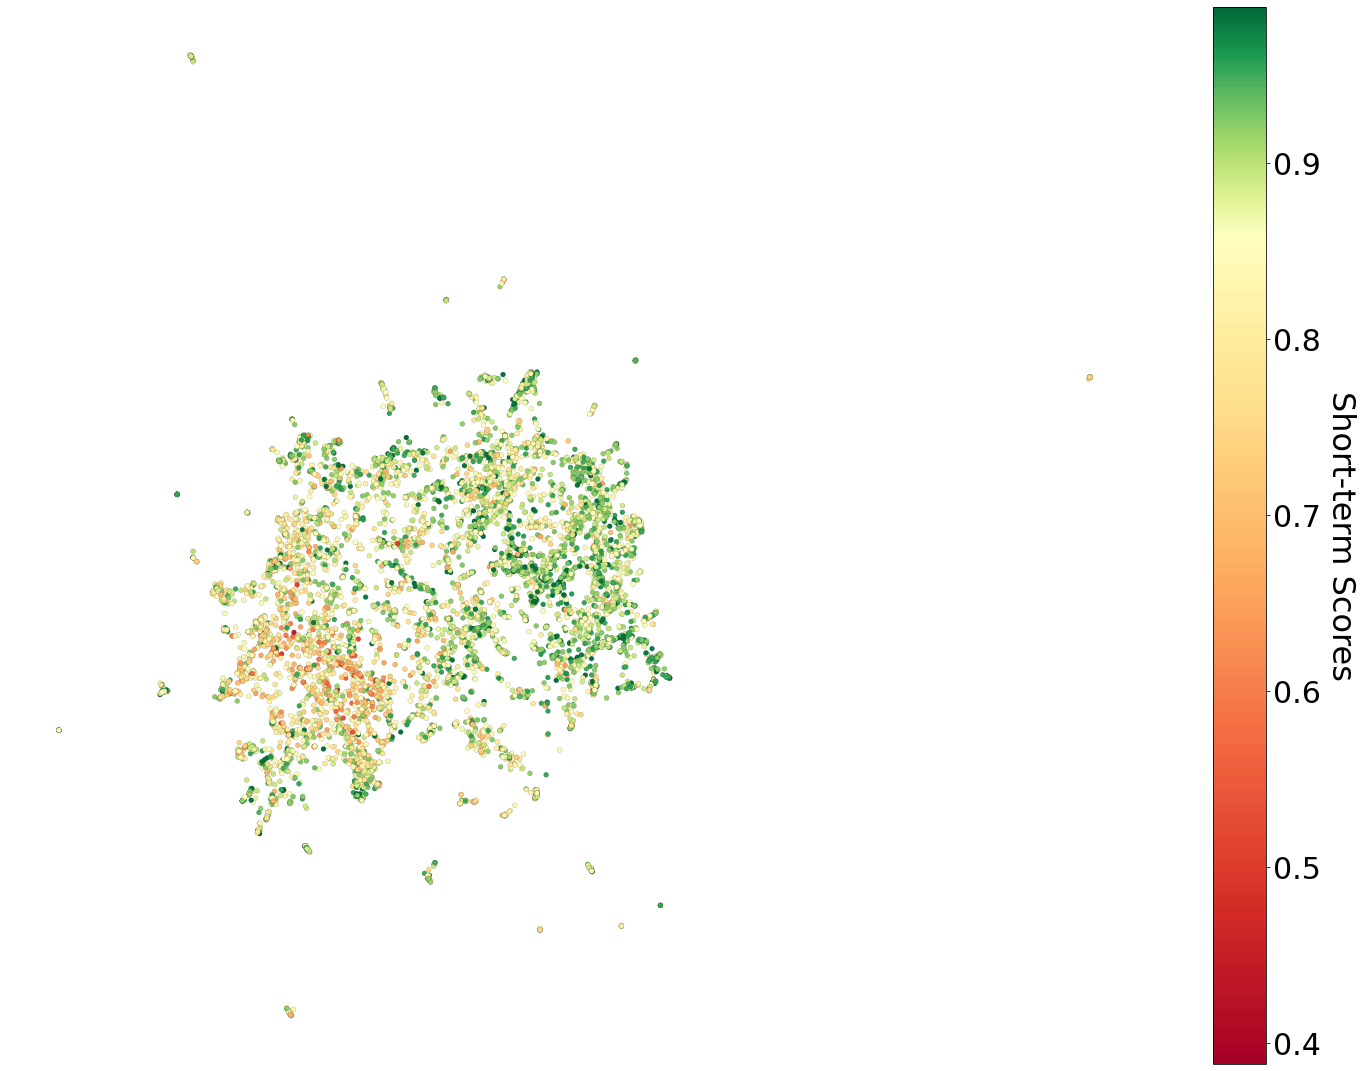

In [6]:
# Primero, reducimos la dimensionalidad de los datos
short_scores = dataset['short'].values
X = Umap(2, 25)(embeddings)
scored_scatter(X, short_scores, 'Short-term Scores')

Se observan regiones donde las puntuaciones son en promedio más bajas en la
esquina inferior izquierda, ¿no es cierto?

¿Y si dicha región se corresponde con una serie te temas específicos?

## Encontrando temas de forma no supervisada

Si nuestra hipótesis es correcta, habría temas que despuntarían por ser más
memorables que otros en promedio. Sin embargo, no tenemos etiquetas que nos
digan qué temas representa cada frase, no explícitamente.

En su lugar, obtendremos dicha información de manera aproximada **a partir
del propio texto**.

Para ello, agregaremos los vectores de frase mediante un procedimiento de
*clustering*, tras lo cual emplearemos una técnica TF-iDF para encontrar,
dentro de cada cluster, los términos más representativos del mismo (Jones, K
.S. (1972)).

Introduciremos aquí la definición de nuestro clustering, HDBSCAN (Malzer, C.
 & Baum, M. (2019)).

In [9]:
class Hdbscan:
    def __init__(self, min_cluster_size: int, metric: str = 'euclidean') -> \
            None:
        """
        Perform HDBSCAN clustering.

        Args:
         min_cluster_size (min): Minimum amount of samples to set a cluster.
         metric (str): Distance measure.
        """
        self.method = HDBSCAN(
            min_cluster_size=min_cluster_size,
            metric=metric,
            cluster_selection_method='eom')

    def fit(self, X: numpy.ndarray) -> None:
        self.method.fit(X)

    def get_labels(self) -> numpy.ndarray:
        return self.method.labels_

    def get_core_samples(self) -> list:
        """
        Select only the most representative samples per cluster.

        Returns:
            list:
        """
        core_samples = []
        for cluster, core in enumerate(self.method.exemplars_):
            core_samples.append((cluster, len(core)))
        return core_samples

    def measure_cluster_size(self) -> List[tuple]:
        """
        Compute the number of labels for the elements
        unique.

        Returns:
            List:tuple
        """
        labels = self.get_labels()
        unique = sorted(list(set(labels)))
        clus_size = []
        for i, cluster in enumerate(unique[1:]):
            clus_size.append((cluster, len(numpy.where(labels == cluster)[0])))
        return clus_size

    def build_as_documents(self, text: Union[List[str], numpy.ndarray],
                           allow_noise: bool = False) -> Dict[int, str]:
        """
        Given a set of predicted labels, aggregate input text according to
        those labels to build document-like objects.

        Args:
            text (List[str]): Sample-wise text to aggregate.
            allow_noise (bool): Whether to remove noisy label (-1).

        Returns:
            Dict[int, str]
        """
        if isinstance(text, list):
            text = numpy.array(text)
        documents = dict()
        labels = self.get_labels()
        unique_labels = sorted(list(set(labels)))
        for i, cluster in enumerate(unique_labels):
            cluster_samples = numpy.where(labels == cluster)[0]
            cluster_text = text[cluster_samples]
            documents[cluster] = cluster_text
        if not allow_noise:
            del documents[-1]
        return documents

Procedemos a agrupar las frases en clusters:

In [15]:
X_umap = Umap(5, 25)(embeddings)
cluster = Hdbscan(50)
cluster.fit(X_umap)
documents = cluster.build_as_documents(dataset['sentence'].values)

En la última línea, hemos aprovechado las agrupaciones que ha realizado
HDBSCAN para agrupar frases que corresponden al mismo cluster, generando de
esa manera una serie de "documentos" de frases. A continuación usaremos la
técnica de índices TF-iDF para encontrar las palabras más representativas de
 cada documento:

In [16]:
def tf_idf(documents: Dict[int, str], top_k: int):
	"""
	Retrieve the top_k most characteristic words in every document according to
	a TF-IDF measure.

	Args:
		documents (Dict[int, str]):
		top_k (int): Number of relevant words per document.

	Returns:
		Dict[int, List[Union[list, Any]]]
	"""
	vectorizer = TfidfVectorizer(strip_accents='unicode',
								 lowercase=True,
								 stop_words='english')
	docs = [' '.join(val) for key, val in documents.items()]
	vec_docs = vectorizer.fit_transform(docs)
	feature_names = vectorizer.get_feature_names()
	relevant_words = dict()
	for i in range(vec_docs.shape[0]):
		row = vec_docs.getrow(i).toarray()[0]
		k_words = numpy.flip(list(numpy.argsort(row)[-top_k:]))
		relevant_words[i] = [feature_names[j] for j in k_words]
	return relevant_words

top_words_per_document = tf_idf(documents, top_k=3)
top_words = [", ".join(words) for words in top_words_per_document.values()]

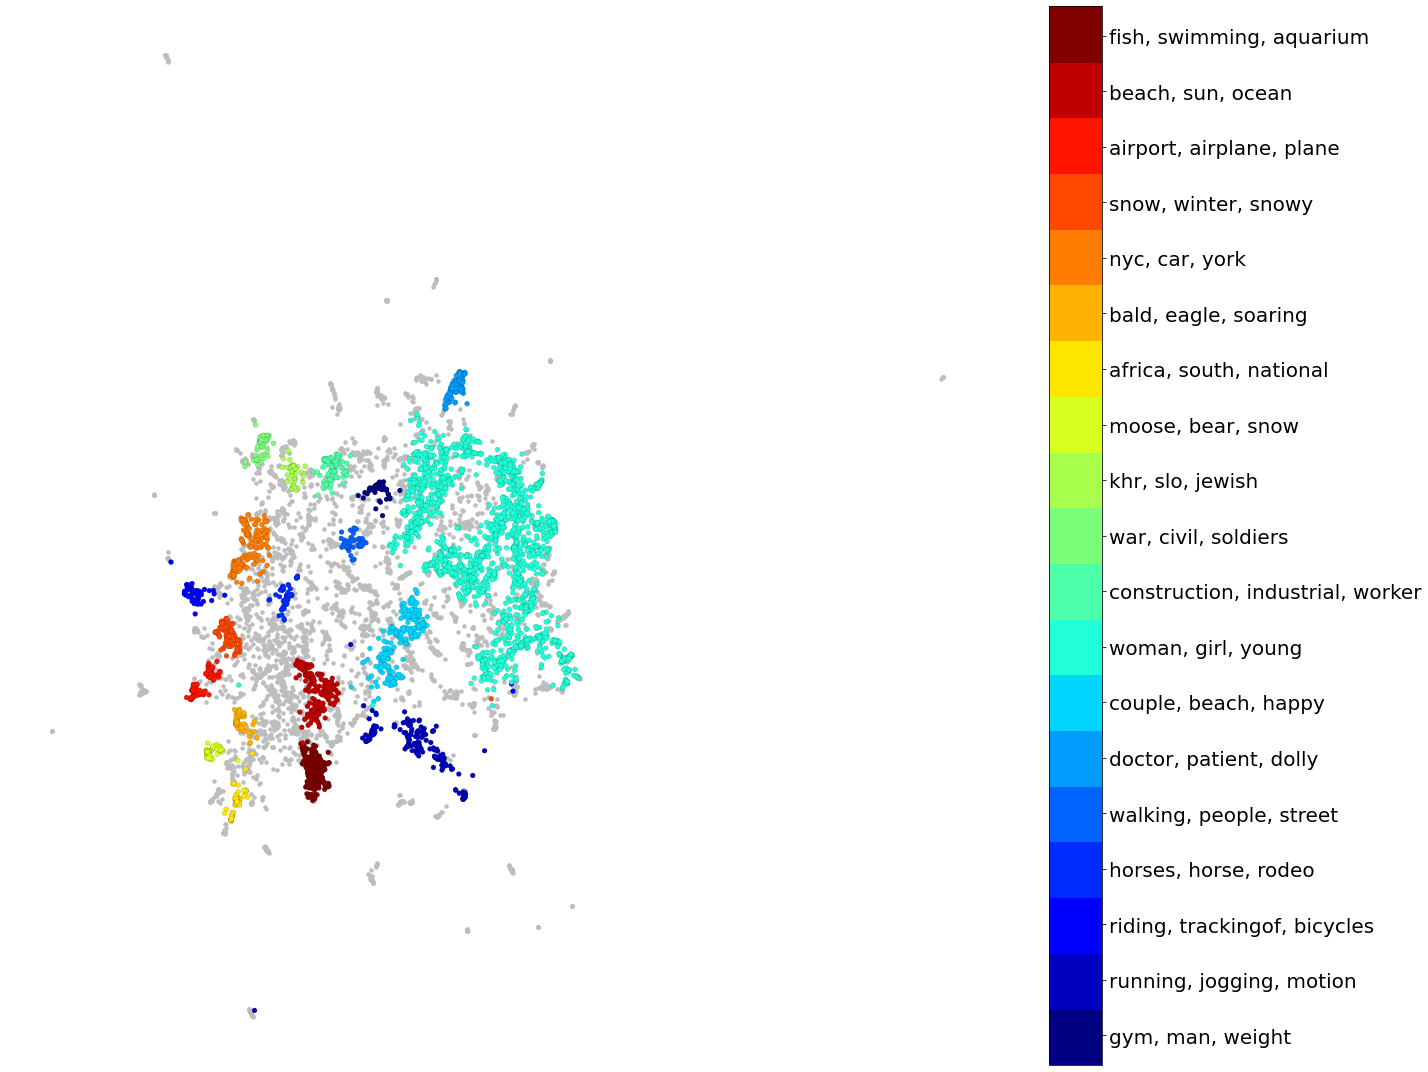

In [17]:
# Pintamos!
cluster_scatter(X, labels=cluster.get_labels(), label_names=top_words)


## ¿Opiniones? :)

¡Dime qué te parece nuestro resultado!
Para poder comparar, recordemos el aspecto que tenían las puntuaciones a
corto plazo

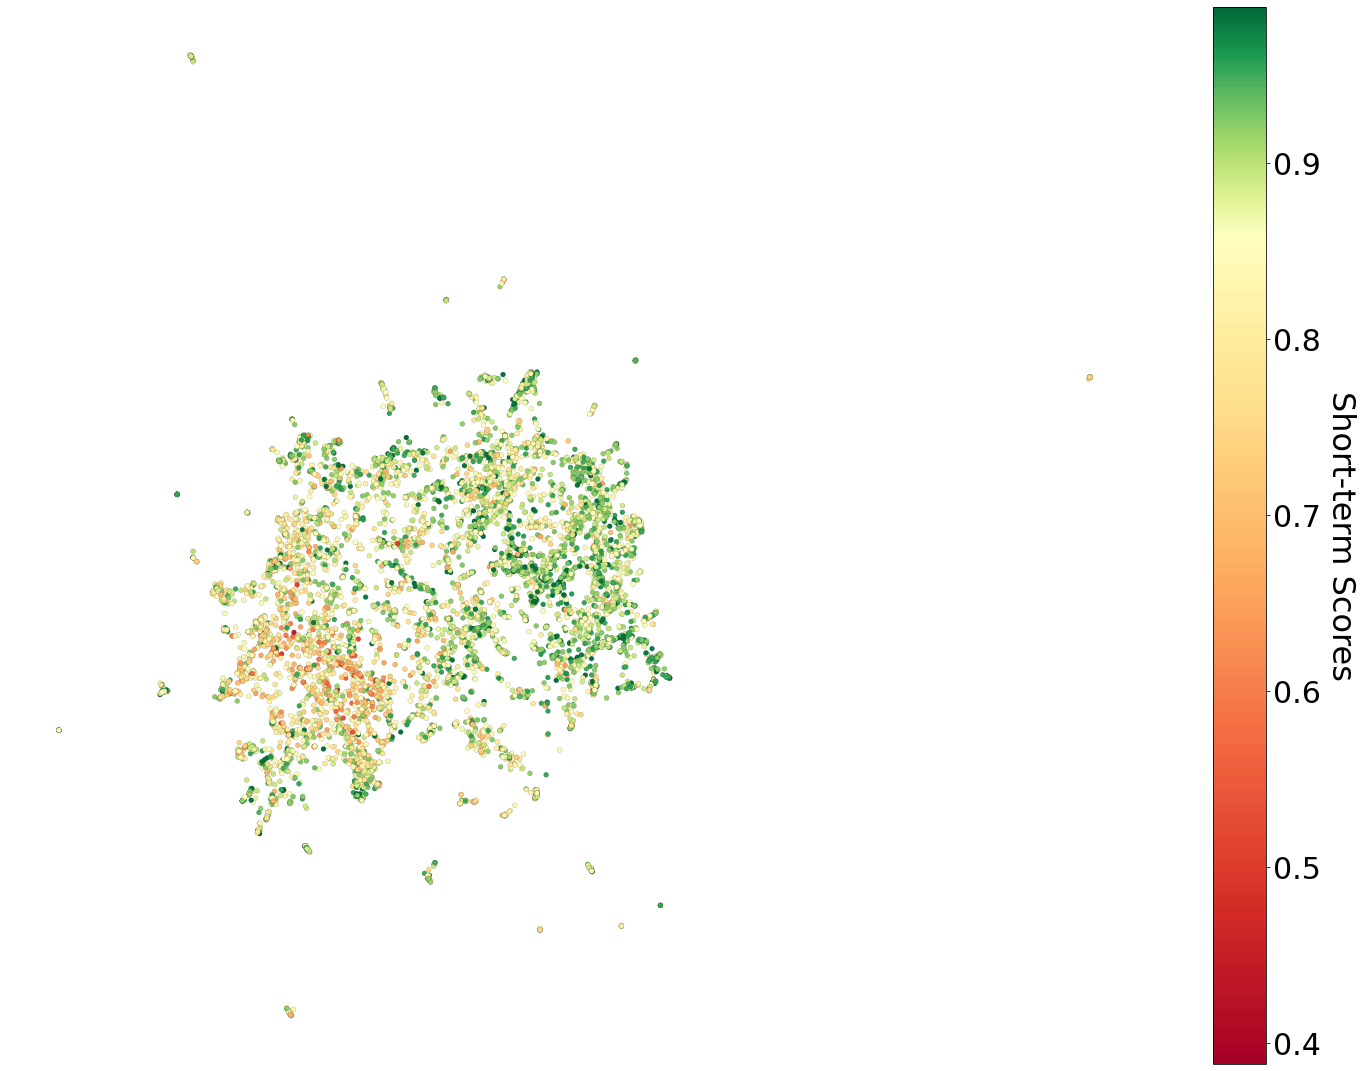

In [18]:
scored_scatter(X, short_scores, 'Short-term Scores')

### Duda razonable: ¿Ocurrirá lo mismo con la memoria a largo plazo?

Puede intentar cambiar los números presentes en las celdas para modificar
aspectos del clustering y la representación. Igualmente, puede representarse
 la memoria a largo plazo, y ver si nuestros resultados se mantienen...

## Referencias

Kleinlein, R.; Luna-Jiménez, C.; Arias-Cuadrado, D.; Ferreiros, J.;
Fernández-Martínez, F. Topic-Oriented Text Features Can Match Visual Deep
Models of Video Memorability. Appl. Sci. 2021, 11, 7406. https://doi.org/10
.3390/app11167406

Cohendet, R., Demarty, C. H., Duong, N. Q., & Engilberge, M. (2019).
VideoMem: constructing, analyzing, predicting short-term and long-term video
 memorability. In Proceedings of the IEEE/CVF International Conference on
 Computer Vision (pp. 2531-2540).

Reimers, N., & Gurevych, I. (2019). Sentence-bert: Sentence embeddings using
 siamese bert-networks. arXiv preprint arXiv:1908.10084.

McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold
approximation and projection for dimension reduction. arXiv preprint
arXiv:1802.03426.

Jones KS (1972). A statistical interpretation of term specificity and its
application in retrieval (1). pp. 11-21. doi:10.1108/eb026526

Malzer, C., & Baum, M. (2020, September). A hybrid approach to hierarchical
density-based cluster selection. In 2020 IEEE International Conference on
Multisensor Fusion and Integration for Intelligent Systems (MFI) (pp.
223-228). IEEE.